In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from transformers import BatchEncoding, GPT2TokenizerFast

from config import load_config

In [2]:
configs = [
    pathlib.Path('config/finetune-rus-pol.json'),
    pathlib.Path('config/finetune-rus-pol-qa-normal.json'),
]
cfg, db = load_config(configs, default_config=pathlib.Path('config/default-local.json'))

In [3]:
russian_dataset_name = cfg['datasets']['russian']
russian_dataset_path = db['russian']['qa'][russian_dataset_name]['dataset']
raw_russian_dataset = load_dataset(russian_dataset_path)
polish_dataset_name = cfg['datasets']['polish']
polish_dataset_path = db['polish']['qa'][polish_dataset_name]['dataset']
raw_polish_dataset = load_dataset(polish_dataset_path)

In [4]:
print(raw_russian_dataset)
print(raw_polish_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'context-phoneme', 'question-phoneme', 'answers-phoneme'],
        num_rows: 45328
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'context-phoneme', 'question-phoneme', 'answers-phoneme'],
        num_rows: 5036
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'context-phoneme', 'question-phoneme', 'answers-phoneme'],
        num_rows: 23936
    })
})
DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'context-phoneme', 'question-phoneme', 'answers-phoneme'],
        num_rows: 46187
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'context-phoneme', 'question-phoneme', 'answers-phoneme'],
        num_rows: 5764
    })
})


In [5]:
print("Context: ", raw_russian_dataset["train"][0]["context"])
print("Question: ", raw_russian_dataset["train"][0]["question"])
print("Answer: ", raw_russian_dataset["train"][0]["answers"])
print("Context: ", raw_polish_dataset["train"][0]["context"])
print("Question: ", raw_polish_dataset["train"][0]["question"])
print("Answer: ", raw_polish_dataset["train"][0]["answers"])

Context:  В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий.
Question:  чем представлены органические остатки?
Answer:  {'text': ['известковыми выделениями сине-зелёных водорослей'], 'answer_start': [109]}
Context:  Projekty konfederacji zaczęły się załamywać 5 sierpnia 1942. Ponownie wróciła kwestia monachijska, co uaktywniło się wymianą listów Ripka – Stroński. Natomiast 17 sierpnia 1942 doszło do spotkania E. Bene

In [6]:
print(len(raw_russian_dataset["train"].filter(lambda x: len(x["answers"]["text"]) != 1)))
print(len(raw_russian_dataset["validation"].filter(lambda x: len(x["answers"]["text"]) != 1)))
print(len(raw_polish_dataset["train"].filter(lambda x: len(x["answers"]["text"]) != 1)))
print(len(raw_polish_dataset["validation"].filter(lambda x: len(x["answers"]["text"]) != 1)))

0
0


Filter:   0%|          | 0/46187 [00:00<?, ? examples/s]

0


Filter:   0%|          | 0/5764 [00:00<?, ? examples/s]

0


In [7]:
class MyGPT2Tokenizer(GPT2TokenizerFast):
    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        # Example: custom separators or structure
        if token_ids_1 is None:
            return [self.eos_token_id] + token_ids_0 + [self.eos_token_id]
        return (
            [self.eos_token_id]
            + token_ids_0
            + [self.eos_token_id]
            + token_ids_1
            + [self.eos_token_id]
        )


def load_tokenizer(vocab: pathlib.Path, merges: pathlib.Path) -> GPT2TokenizerFast:
    # ---- Load tokenizer ----
    tokenizer = MyGPT2Tokenizer(
        vocab_file=str(vocab),
        merges_file=str(merges),
        add_prefix_space=True,
    )

    # # Set pad_token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = 'right'

    return tokenizer

In [8]:
tokenizer_settings = cfg["tokenizers"]
normal_tokenizer_name = tokenizer_settings[f'normal_prefix']

normal_tokenizer = load_tokenizer(
    pathlib.Path(tokenizer_settings["prefix"]) / f'{normal_tokenizer_name}-vocab.json',
    pathlib.Path(tokenizer_settings["prefix"]) / f'{normal_tokenizer_name}-merges.txt',
)
normal_tokenizer.add_eos_token = True

ipa_tokenizer_name = tokenizer_settings[f'ipa_prefix']

ipa_tokenizer = load_tokenizer(
    pathlib.Path(tokenizer_settings["prefix"]) / f'{ipa_tokenizer_name}-vocab.json',
    pathlib.Path(tokenizer_settings["prefix"]) / f'{ipa_tokenizer_name}-merges.txt',
)
ipa_tokenizer.add_eos_token = True

In [9]:
def encode_data(q: str, c: str, toke: GPT2TokenizerFast) -> BatchEncoding:
    qcs = f'{toke.pad_token} {q} {toke.pad_token} {c} {toke.pad_token}'
    return toke(qcs)

Check the max length for each language

In [10]:
def calculate_encoding_length(example):
    normal_tokens = encode_data(example['question'], example['context'], normal_tokenizer)
    ipa_tokens = encode_data(example['question-phoneme'], example['context-phoneme'], ipa_tokenizer)
    example['normal_length'] = len(normal_tokens['input_ids'])
    example['ipa_length'] = len(ipa_tokens['input_ids'])
    return example

meta_russian_dataset = raw_russian_dataset.map(calculate_encoding_length)
meta_polish_dataset = raw_polish_dataset.map(calculate_encoding_length)

Map:   0%|          | 0/46187 [00:00<?, ? examples/s]

Map:   0%|          | 0/5764 [00:00<?, ? examples/s]

In [11]:
for ds in [meta_russian_dataset, meta_polish_dataset]:
    for split in ['train', 'validation']:
        for mtype in ['normal', 'ipa']:
            print(f'{split}-{mtype}')
            print('Max token length:', max(ds[split][f'{mtype}_length']))
            print('Avg token length:', np.mean(ds[split][f'{mtype}_length']))
            print('Token length deviation:', np.std(ds[split][f'{mtype}_length']))

train-normal
Max token length: 2082
Avg token length: 208.87283798093893
Token length deviation: 86.69307787306761
train-ipa
Max token length: 1952
Avg token length: 201.8111321920226
Token length deviation: 82.38975483564286
validation-normal
Max token length: 1448
Avg token length: 207.8381652104845
Token length deviation: 86.54822204303147
validation-ipa
Max token length: 1353
Avg token length: 200.63602065131056
Token length deviation: 82.26137635659994
train-normal
Max token length: 2519
Avg token length: 283.75330720765584
Token length deviation: 131.5902204785123
train-ipa
Max token length: 2564
Avg token length: 291.3003442527118
Token length deviation: 134.24326790211703
validation-normal
Max token length: 1093
Avg token length: 285.5324427480916
Token length deviation: 127.74486014885045
validation-ipa
Max token length: 1110
Avg token length: 293.25416377515614
Token length deviation: 130.47258802748877


In [12]:
filtered_meta_russian = meta_russian_dataset.filter(lambda r: r['normal_length'] <= 1024 and r['ipa_length'] <= 1024)
filtered_meta_polish = meta_polish_dataset.filter(lambda r: r['normal_length'] <= 1024 and r['ipa_length'] <= 1024)
print(len(meta_russian_dataset['train']), '->', len(filtered_meta_russian['train']))
print(len(meta_russian_dataset['validation']), '->', len(filtered_meta_russian['validation']))
print(len(meta_polish_dataset['train']), '->', len(filtered_meta_polish['train']))
print(len(meta_polish_dataset['validation']), '->', len(filtered_meta_polish['validation']))

Filter:   0%|          | 0/46187 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5764 [00:00<?, ? examples/s]

45328 -> 45312
5036 -> 5033
46187 -> 46076
5764 -> 5756


In [13]:
context = raw_russian_dataset["train"][0]["context"]
question = raw_russian_dataset["train"][0]["question"]

assert normal_tokenizer.eos_token_id == 50000

inputs = encode_data(question, context, normal_tokenizer)
print(inputs)
normal_tokenizer.decode(inputs["input_ids"])
len(inputs["input_ids"])

{'input_ids': [50000, 1253, 7804, 37081, 17114, 30, 220, 50000, 383, 7375, 337, 405, 318, 1411, 11655, 3471, 37081, 17114, 11468, 6915, 4018, 11, 1253, 281, 4724, 392, 1411, 13, 2458, 7804, 2345, 3426, 1549, 3026, 4048, 280, 1512, 12, 17244, 790, 543, 31243, 1775, 11, 5630, 593, 44353, 11, 10445, 7571, 5037, 2457, 121, 1526, 314, 1551, 13, 2754, 2345, 1218, 1966, 31243, 1775, 11, 290, 21576, 4323, 23935, 36680, 29501, 6571, 36890, 31116, 116, 309, 12, 1561, 17790, 347, 6175, 11, 5198, 35833, 281, 3506, 490, 11048, 913, 5031, 761, 2899, 1322, 460, 70, 34280, 2899, 13, 383, 5417, 17441, 587, 520, 435, 14561, 3520, 7078, 14918, 1839, 1003, 37035, 37595, 15238, 5003, 547, 31243, 455, 11, 4723, 547, 26585, 220, 140, 116, 4212, 11, 26133, 19746, 8019, 40268, 6043, 417, 476, 348, 13, 383, 3520, 14135, 2162, 7475, 1864, 18963, 17631, 220, 140, 116, 22765, 28845, 3520, 14733, 5327, 23309, 16461, 13, 220, 50000], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

155

Find max answer length hyperparameters

In [14]:
def find_answer_lengths(dataset):
    def process(example):
        normal_answer_len = len(normal_tokenizer(example['answers']['text'][0])['input_ids'])
        ipa_answer_len = len(ipa_tokenizer(example['answers-phoneme']['text'][0])['input_ids'])
        return {
            'normal_answer_length': normal_answer_len,
            'ipa_answer_length': ipa_answer_len,
        }

    return dataset.map(process, num_proc=os.cpu_count())

In [15]:
filtered_meta_russian_answer_lengths = find_answer_lengths(filtered_meta_russian)

In [16]:
filtered_meta_polish_answer_lengths = find_answer_lengths(filtered_meta_polish)

Map (num_proc=12):   0%|          | 0/46076 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/5756 [00:00<?, ? examples/s]

In [17]:
for ds in [filtered_meta_russian_answer_lengths, filtered_meta_polish_answer_lengths]:
    for split in ['train', 'validation']:
        for mtype in ['normal', 'ipa']:
            print(f'{split}-{mtype}')
            print('Max token length:', max(ds[split][f'{mtype}_answer_length']))
            print('Avg token length:', np.mean(ds[split][f'{mtype}_answer_length']))
            print('Token length deviation:', np.std(ds[split][f'{mtype}_answer_length']))

train-normal
Max token length: 225
Avg token length: 6.59765625
Token length deviation: 5.137451009545493
train-ipa
Max token length: 72
Avg token length: 5.7068326271186445
Token length deviation: 4.728909757650025
validation-normal
Max token length: 51
Avg token length: 6.6932247168686665
Token length deviation: 4.958527365516985
validation-ipa
Max token length: 49
Avg token length: 5.832306775283131
Token length deviation: 4.650179978919945
train-normal
Max token length: 471
Avg token length: 12.317497178574529
Token length deviation: 13.895979139914434
train-ipa
Max token length: 460
Avg token length: 12.624251237086552
Token length deviation: 14.230792156002877
validation-normal
Max token length: 458
Avg token length: 12.71455872133426
Token length deviation: 16.20041491319975
validation-ipa
Max token length: 456
Avg token length: 13.05767894371091
Token length deviation: 16.642047867543926


# Answer Start Distribution

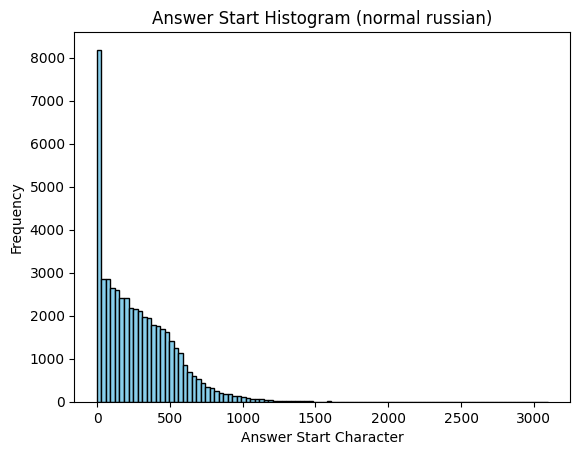

In [24]:
answer_starts = [a['answer_start'][0] for a in filtered_meta_russian_answer_lengths['train']['answers']] + [a['answer_start'][0] for a in filtered_meta_russian_answer_lengths['validation']['answers']]

plt.hist(answer_starts, bins=100, color='skyblue', edgecolor='black')

plt.xlabel('Answer Start Character')
plt.ylabel('Frequency')
plt.title('Answer Start Histogram (normal russian)')
plt.show()

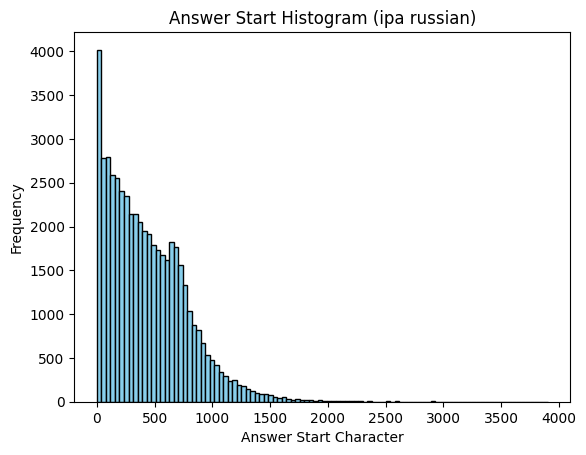

In [25]:
answer_starts = [a['answer_start'][0] for a in filtered_meta_russian_answer_lengths['train']['answers-phoneme']] + [a['answer_start'][0] for a in filtered_meta_russian_answer_lengths['validation']['answers-phoneme']]

plt.hist(answer_starts, bins=100, color='skyblue', edgecolor='black')

plt.xlabel('Answer Start Character')
plt.ylabel('Frequency')
plt.title('Answer Start Histogram (ipa russian)')
plt.show()

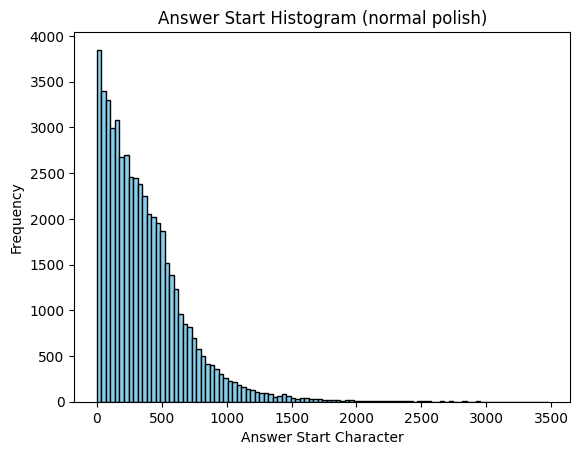

In [27]:
answer_starts = [a['answer_start'][0] for a in filtered_meta_polish_answer_lengths['train']['answers']] + [a['answer_start'][0] for a in filtered_meta_polish_answer_lengths['validation']['answers']]

plt.hist(answer_starts, bins=100, color='skyblue', edgecolor='black')

plt.xlabel('Answer Start Character')
plt.ylabel('Frequency')
plt.title('Answer Start Histogram (normal polish)')
plt.show()

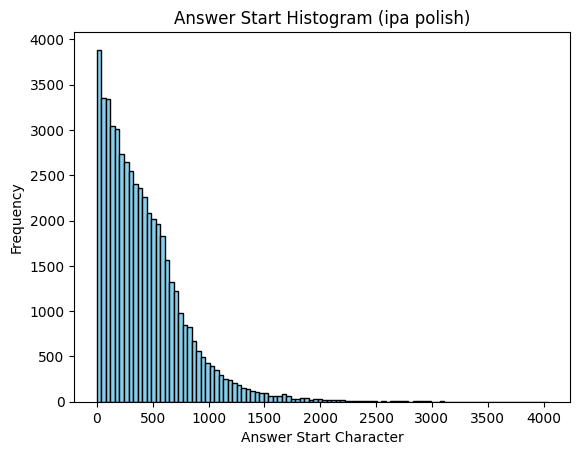

In [26]:
answer_starts = [a['answer_start'][0] for a in filtered_meta_polish_answer_lengths['train']['answers-phoneme']] + [a['answer_start'][0] for a in filtered_meta_polish_answer_lengths['validation']['answers-phoneme']]

plt.hist(answer_starts, bins=100, color='skyblue', edgecolor='black')

plt.xlabel('Answer Start Character')
plt.ylabel('Frequency')
plt.title('Answer Start Histogram (ipa polish)')
plt.show()